In [9]:
import os
import pandas as pd
#from scipy.misc import imread
from imageio import imread
import math
import numpy as np
import cv2
import keras
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras.models import Sequential

import matplotlib.pyplot as plt
import numpy as np


In [10]:
def load_data(input_size = (64,64), data_path =  'GTSRB/Final_Training/Images'):

    pixels = []
    labels = []
    # Loop qua các thư mục trong thư mục Images
    for dir in os.listdir(data_path):
        if dir == '.DS_Store':
            continue

        # Đọc file csv để lấy thông tin về ảnh
        class_dir = os.path.join(data_path, dir)
        info_file = pd.read_csv(os.path.join(class_dir, "GT-" + dir + '.csv'), sep=';')

        # Lăp trong file
        for row in info_file.iterrows():
            # Đọc ảnh
            pixel = imread(os.path.join(class_dir, row[1].Filename))
            # Trích phần ROI theo thông tin trong file csv
            pixel = pixel[row[1]['Roi.X1']:row[1]['Roi.X2'], row[1]['Roi.Y1']:row[1]['Roi.Y2'], :]
            # Resize về kích cỡ chuẩn
            img = cv2.resize(pixel, input_size)

            # Thêm vào list dữ liệu
            pixels.append(img)

            # Thêm nhãn cho ảnh
            labels.append(row[1].ClassId)

    return pixels, labels



In [11]:
# Đường dẫn ảnh
data_path = 'GTSRB/Final_Training/Images'
pixels, labels = load_data(data_path=data_path)



C:\Users\pc\AppData\Local\Temp\ipykernel_15752\499263226.py:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  pixel = imread(os.path.join(class_dir, row[1].Filename))
C:\Users\pc\AppData\Local\Temp\ipykernel_15752\499263226.py:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  pixel = imread(os.path.join(class_dir, row[1].Filename))
C:\Users\pc\AppData\Local\Temp\ipykernel_15752\499263226.py:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imag

In [12]:

def split_train_val_test_data(pixels, labels):

    # Chuẩn hoá dữ liệu pixels và labels
    pixels = np.array(pixels)
    labels = keras.utils.np_utils.to_categorical(labels)

    # Nhào trộn dữ liệu ngẫu nhiên
    randomize = np.arange(len(pixels))
    np.random.shuffle(randomize)
    X = pixels[randomize]
    print("X=", X.shape)
    y = labels[randomize]

    # Chia dữ liệu theo tỷ lệ 60% train và 40% còn lại cho val và test
    train_size = int(X.shape[0] * 0.6)
    X_train, X_val = X[:train_size], X[train_size:]
    y_train, y_val = y[:train_size], y[train_size:]

    val_size = int(X_val.shape[0] * 0.5) # 50% của phần 40% bên trên
    X_val, X_test = X_val[:val_size], X_val[val_size:]
    y_val, y_test = y_val[:val_size], y_val[val_size:]

    return X_train, y_train, X_val, y_val, X_test, y_test


X_train, y_train, X_val, y_val, X_test, y_test = split_train_val_test_data(pixels, labels)




X= (39209, 64, 64, 3)


In [13]:
def build_model(input_shape=(64,64,3), filter_size = (3,3), pool_size = (2, 2), output_size = 43):
    model = Sequential([
        Conv2D(16, filter_size, activation='relu', input_shape=input_shape, padding='same'),
        BatchNormalization(),
        Conv2D(16, filter_size, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=pool_size),
        Dropout(0.2),
        Conv2D(32, filter_size, activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(32, filter_size, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=pool_size),
        Dropout(0.2),
        Conv2D(64, filter_size, activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, filter_size, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=pool_size),
        Dropout(0.2),
        Flatten(),
        Dense(2048, activation='relu'),
        Dropout(0.3),
        Dense(1024, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(output_size, activation='softmax')
    ])

    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4), metrics=['accuracy'])
    model.summary()
    return model



In [14]:
# Build model với kích thước đầu vào 64x64 và output là 43 classes
model = build_model(input_shape=(64,64,3), output_size=43)

# Train model
epochs = 10
batch_size = 16

model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                               validation_data=(X_val, y_val))

model.save("traffic_sign_model.h5")
#model = keras.models.load_model("traffic_sign_model.h5")

# Kiểm tra model với dữ liệu mới
print(model.evaluate(X_test, y_test))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 16)        2320      
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 16)       64        
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                        

c:\Users\pc\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
1471/1471 [==============================] - 481s 326ms/step - loss: 2.4356 - accuracy: 0.3518 - val_loss: 0.8897 - val_accuracy: 0.7466
Epoch 2/10
1471/1471 [==============================] - 6133s 4s/step - loss: 0.8367 - accuracy: 0.7481 - val_loss: 0.2168 - val_accuracy: 0.9382
Epoch 3/10
1471/1471 [==============================] - 383s 261ms/step - loss: 0.3491 - accuracy: 0.8951 - val_loss: 0.1145 - val_accuracy: 0.9658
Epoch 4/10
1471/1471 [==============================] - 328s 223ms/step - loss: 0.1881 - accuracy: 0.9417 - val_loss: 0.0658 - val_accuracy: 0.9829
Epoch 5/10
1471/1471 [==============================] - 336s 228ms/step - loss: 0.1218 - accuracy: 0.9626 - val_loss: 0.0480 - val_accuracy: 0.9860
Epoch 6/10
1471/1471 [==============================] - 382s 260ms/step - loss: 0.0877 - accuracy: 0.9737 - val_loss: 0.0422 - val_accuracy: 0.9889
Epoch 7/10
1471/1471 [==============================] - 375s 255ms/step - loss: 0.0667 - accuracy: 0.9787 - val_lo

In [15]:
X_train.shape

(23525, 64, 64, 3)

đánh giá mô hình

C:\Users\pc\AppData\Local\Temp\ipykernel_15752\1811107939.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  test=imread("D:\\vscode2\\Ai\\baitaplonAi\\bien70.png")


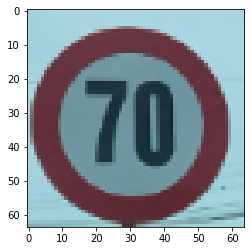

In [28]:
#test
test=imread("D:\\vscode2\\Ai\\baitaplonAi\\bien70.png")

test=cv2.resize(test,(64,64))
test=cv2.cvtColor(test,cv2.COLOR_RGBA2RGB)
#test.shape
plt.imshow(test)


In [29]:
Signboard=[]
with open('Bienbao.txt', encoding = 'utf-8') as file:
  for line in file:
    Signboard.append(line)
def predict(X):
  predict = model.predict(X)
  index = np.argmax(predict, axis=1)
  return index

In [30]:
test=np.array([test])

In [31]:
print(Signboard[predict(test)[0]])

1/1 [==============================] - 0s 52ms/step
Tốc độ tối đa cho phép:70



In [20]:
my_image_index =96
image = X_test[my_image_index]
test= np.array([X_test[my_image_index]])


1/1 [==============================] - 0s 51ms/step
Thú rừng vượt qua đường



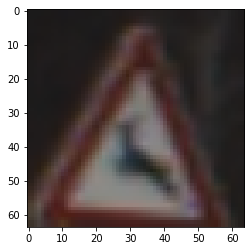

In [21]:
test = np.array([X_test[0]])
predict = model.predict(test)
plt.imshow(X_test[0])
Signboard=[]
with open('Bienbao.txt', encoding = 'utf-8') as file:
  for line in file:
    Signboard.append(line)
def predict(X):
  predict = model.predict(X)
  index = np.argmax(predict, axis=1)
  return index
print(Signboard[predict(test)[0]])


hiệu suất trainning
độ hội tụ

In [22]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

NameError: name 'history' is not defined

độ chính xác trainning

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

NameError: name 'history' is not defined